# DeepAR: Multi Time series
### Train with Full Dataset

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss

from evaluation import Metric, Evaluation
from plotting import Plot, ModelEvaluation
from time_series import TsHandler
from preprocess import Preprocessor, Dataset, Scaler
from multi_horizon import Prediction
from config.get_config import ConfigHandler, HOME_PATH

import warnings
warnings.filterwarnings('ignore')

import random
seed = 42

In [9]:
# Read model_params from notebooks/config/model_params.yml
model_params = ConfigHandler.read_yml("model_params_path")

HORIZON = model_params['common']['horizon']
WINDOWSIZE = HORIZON*3    #model_params['common']['windowsize']

print(f"windowsize:{WINDOWSIZE}")
print(f"horizon:{HORIZON}")
print(f"HOME_PATH:{HOME_PATH}")

windowsize:84
horizon:28
HOME_PATH:D:/jupyter-notebook/Kaggle/m5-forecasting-accuracy/m5-kedro-mlflow


In [10]:
df_sales = pd.read_csv('./data/sales_train_evaluation.csv')
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [11]:
# agg to item lvl for obtaining multi time series with obvious patterns
df = df_sales.drop(columns=[
    'id',
    # 'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
    ])
df_item_id = df.groupby(['item_id']).sum()
df_item_id

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,8,6,11,9,7,7,10,6,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,15,16,25,9,7,25,19,25,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,5,4,1,3,2,4,2,8,7,5,...,5,7,11,4,8,3,4,5,4,7
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,4,0,5,3,6,3,0,9,3,4
HOUSEHOLD_2_514,4,8,2,1,1,2,3,8,2,1,...,2,2,2,6,1,0,1,4,3,3


In [12]:
unpivot = pd.melt(
    df_item_id.T.reset_index(drop=True).reset_index().rename(columns={'index': 'time_idx'}),
    id_vars = 'time_idx',
    var_name = 'item_id'
)
unpivot['category'] = unpivot['item_id'].str.split("_").str[0]

unpivot

,time_idx,item_id,value,category
0,0,FOODS_1_001,6,FOODS
1,1,FOODS_1_001,6,FOODS
2,2,FOODS_1_001,4,FOODS
3,3,FOODS_1_001,6,FOODS
4,4,FOODS_1_001,7,FOODS
...,...,...,...,...
5918104,1936,HOUSEHOLD_2_516,1,HOUSEHOLD
5918105,1937,HOUSEHOLD_2_516,1,HOUSEHOLD
5918106,1938,HOUSEHOLD_2_516,3,HOUSEHOLD
5918107,1939,HOUSEHOLD_2_516,4,HOUSEHOLD


In [13]:
# It is important to set "value" from int to float
# Otherwises, KeyError: "Unknown category '923' encountered. Set `add_nan=True` to allow unknown categories"
unpivot = unpivot.astype({"value": "float64"})
unpivot.dtypes

time_idx      int64
item_id      object
value       float64
category     object
dtype: object

## Data Imbalance
- Balanced: FOODS_3_: 252, 555, 714, 694, 226, 377, 080, 099, 804
- Imbalanced: HOUSEHOLD_2_140

In [14]:
# create dataset and dataloaders
context_length = WINDOWSIZE
prediction_length = HORIZON
training_cutoff = unpivot["time_idx"].max() - prediction_length

unpivot_training_set = unpivot[unpivot["time_idx"] <= training_cutoff]
# unpivot_valid_set = unpivot[unpivot["time_idx"] > training_cutoff]
encoder = NaNLabelEncoder(add_nan=True).fit(unpivot_training_set["category"])

train_dataset = TimeSeriesDataSet(
    unpivot_training_set,
    time_idx = "time_idx",
    target = "value",
    categorical_encoders = {"category": encoder},
    group_ids = ["item_id"],
    static_categoricals = ["category"],
    time_varying_unknown_reals = ["value"],
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    # static_reals=[ ... ],
    # time_varying_known_categoricals=[ ... ],
    # time_varying_known_reals=[ ... ],
    # time_varying_unknown_categoricals=[ ... ],
    # time_varying_unknown_reals=[ ... ],
    # variable_groups
)

val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, unpivot, min_prediction_idx=training_cutoff + 1)

In [15]:
batch_size = 512
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = train_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=4, 
    # batch_sampler="synchronized"    # for DEEPVAR
)
val_dataloader = val_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, 
    # batch_sampler="synchronized"    # for DEEPVAR
)

In [16]:
len(train_dataloader)

10731

In [17]:
len(val_dataloader)

6

In [18]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.3048, device='cuda:0')

In [23]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    train_dataset,
    learning_rate=1e-2,
    hidden_size=2048,
    rnn_layers=2,
    loss=NormalDistributionLoss(),   #MultivariateNormalDistributionLoss(rank=30),   # for DEEPVAR
    optimizer="Adam",
)

Seed set to 42
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
Learning rate set to 0.00012882495516931342
Restoring states from the checkpoint path at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_af5a34f3-408b-468f-972c-3f37fdac2641.ckpt
Restored all states from the checkpoint at d:\jupyter-notebook\Kaggle\m5-forecasting-accuracy\m5-kedro-mlflow\notebooks\.lr_find_af5a34f3-408b-468f-972c-3f37fdac2641.ckpt


suggested learning rate: 0.00012882495516931342


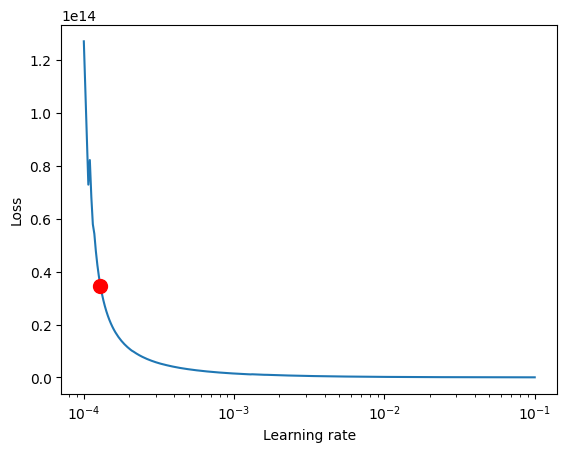

In [24]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-4,
    max_lr=1e-1,
    num_training=300
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()    #2048,2: 0.00012882495516931342

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    default_root_dir=f'{HOME_PATH}/notebooks/saved/model/'
)

# net.hparams.learning_rate = 0.01

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 9     
3 | rnn                    | LSTM                   | 11.8 K
4 | distribution_projector | Linear                 | 62    
------------------------------------------------------------------
11.8 K    Trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer.checkpoint_callback.best_model_path

'D:\\jupyter-notebook\\Kaggle\\m5-forecasting-accuracy\\m5-kedro-mlflow\\notebooks\\saved\\model\\lightning_logs\\version_7\\checkpoints\\epoch=29-step=1050.ckpt'

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
SMAPE()(predictions.output, predictions.y)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


tensor(0.0658, device='cuda:0')

In [ ]:
Metric.smape(predictions.y[0].cpu().numpy(), predictions.output.cpu().numpy())

0.06578251

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="gpu")
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


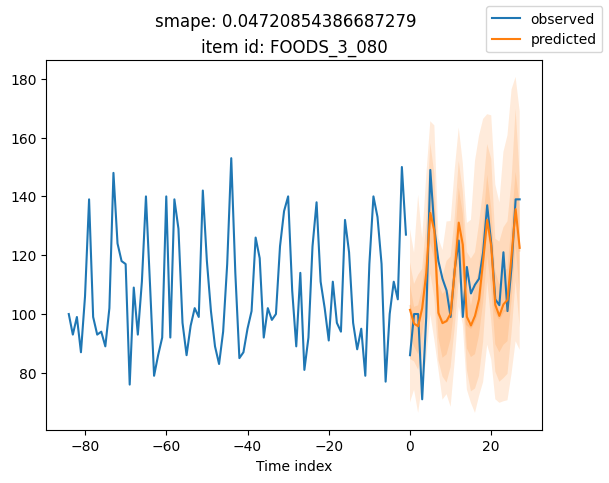

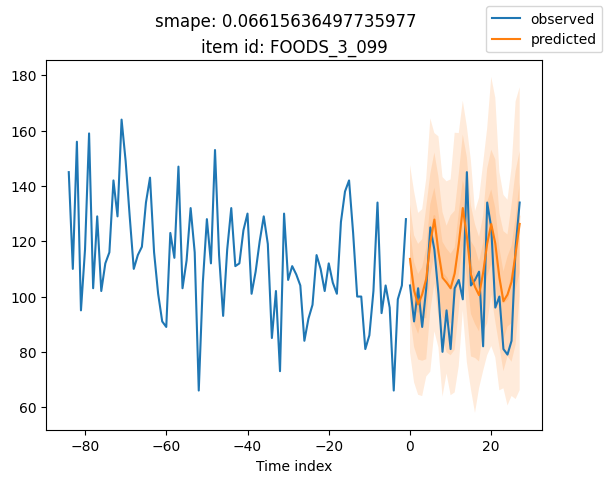

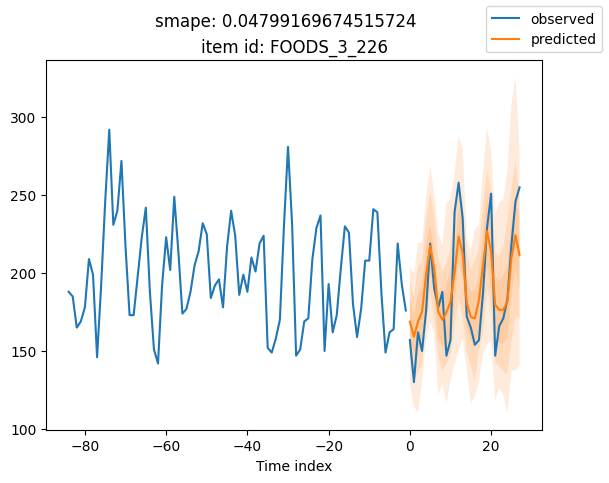

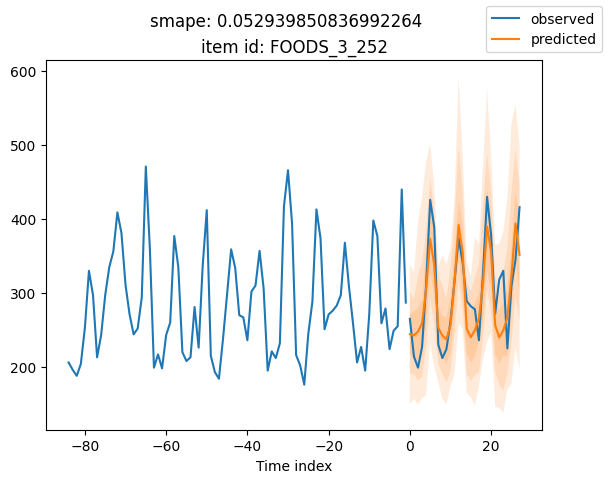

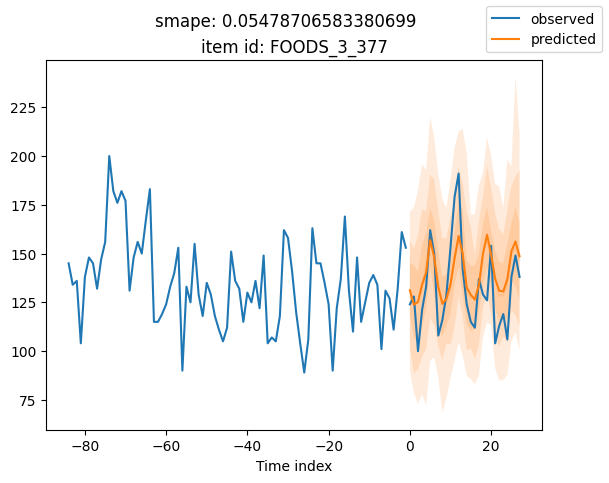

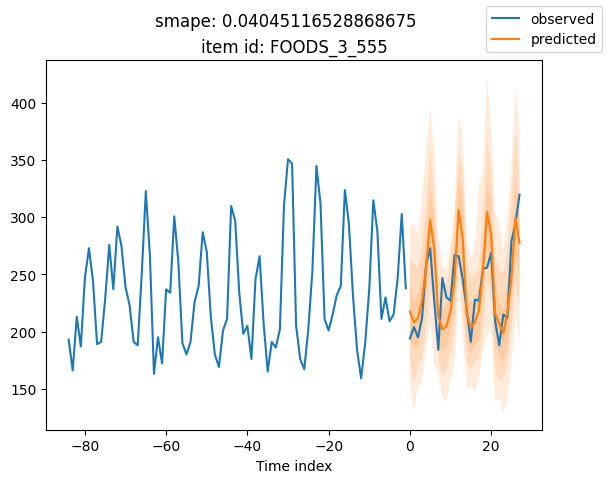

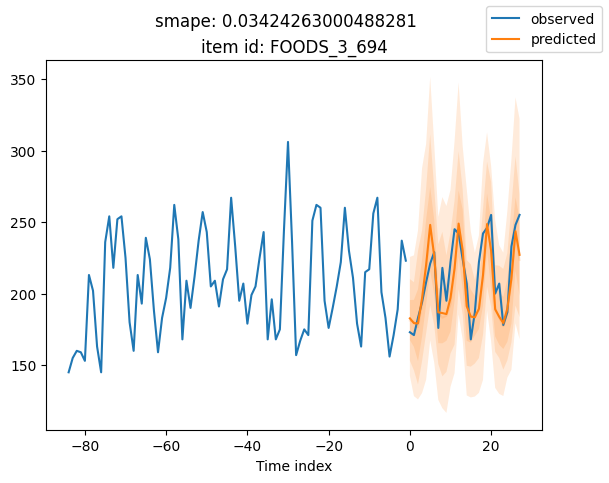

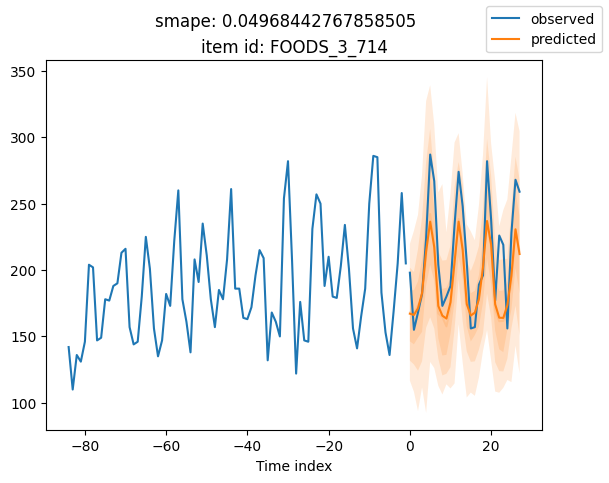

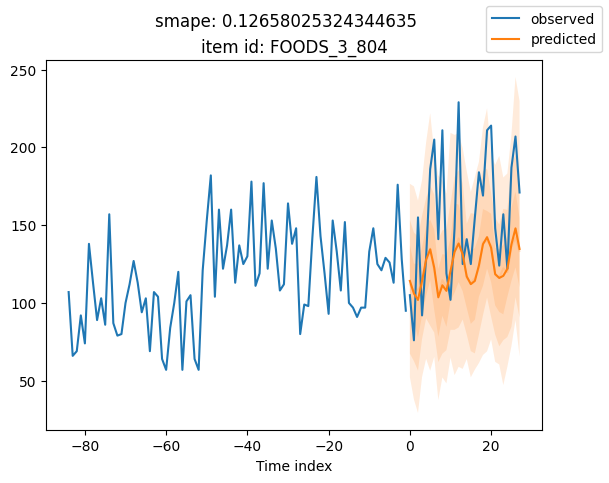

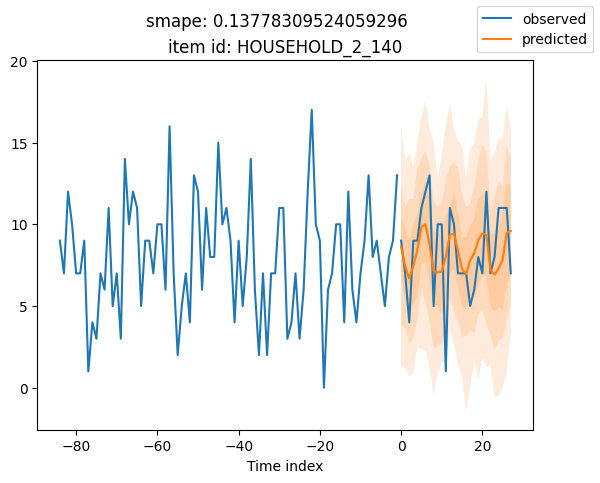

In [ ]:
# TODO: just display the plot of eval names
eval_names = ['FOODS_3_252', 'FOODS_3_555', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226', 'FOODS_3_377', 'FOODS_3_080', 'FOODS_3_099', 'FOODS_3_804']

item_id = val_dataset.x_to_index(raw_predictions.x)["item_id"]
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=False)
    plt.title(f"item id: {item_id.iloc[idx]}")
    plt.suptitle(f"smape: {Metric.smape(predictions.y[0][idx].cpu().numpy(), predictions.output[idx].cpu().numpy())}")

In [ ]:
# cov_matrix = best_model.loss.map_x_to_distribution(
#     best_model.predict(
#         val_dataloader, mode=("raw", "prediction"), n_samples=None, trainer_kwargs=dict(accelerator="cpu")
#     )
# ).base_dist.covariance_matrix.mean(0)

# # normalize the covariance matrix diagnoal to 1.0
# correlation_matrix = cov_matrix / torch.sqrt(torch.diag(cov_matrix)[None] * torch.diag(cov_matrix)[None].T)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(correlation_matrix, cmap="bwr")

# # distribution of off-diagonal correlations
# plt.hist(correlation_matrix[correlation_matrix < 1].numpy())